# Setup & Configuration


In [2]:
# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Data Handling and Splitting
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Evaluation metrics  f1_score: Doğruluk ve duyarlılık ortalaması
from sklearn.metrics import classification_report, f1_score

# Visualization
import plotly.express as px

# Hugging Face Datasets and Transformers
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

# Utilities
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# PEFT (Parameter-Efficient Fine-Tuning)
# Büyük modelleri çok daha az parametreyle eğitmek için kullanılır.
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# get_peft_model = Var olan modeli LoRA moduna sokar
#prepare_model_for_kbit_training = Modeli 4-bit / 8-bit gibi düşük RAM ile eğitime hazır hale getirir (QLoRA gibi teknikler)

2025-05-20 16:56:15.049940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747760175.283635      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747760175.352764      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ✅ Device Selection
**Bu kod bloğu, çalıştığın sistemde hangi donanım hızlandırıcısının (GPU, Apple MPS veya CPU) kullanılabilir olduğunu kontrol eder ve uygun olanı seçer**

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: cuda


# Load Dataset

In [5]:
df = pd.read_csv("/kaggle/input/medicaltranscriptions/mtsamples.csv")
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [8]:
df = df[['transcription', 'medical_specialty']].dropna().reset_index(drop=True)
df.head()

,transcription,medical_specialty
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary


In [12]:
df['transcription'] = df['transcription'].astype(str)


In [15]:
#transcription ve medical_specialty sütununda kaç farklı sınıf (kategori) olduğunu sayar.

num_classes = df['transcription'].nunique()
print(f"Number of unique classes: {num_classes}")

num_classes = df['medical_specialty'].nunique()
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 2357
Number of unique classes: 40


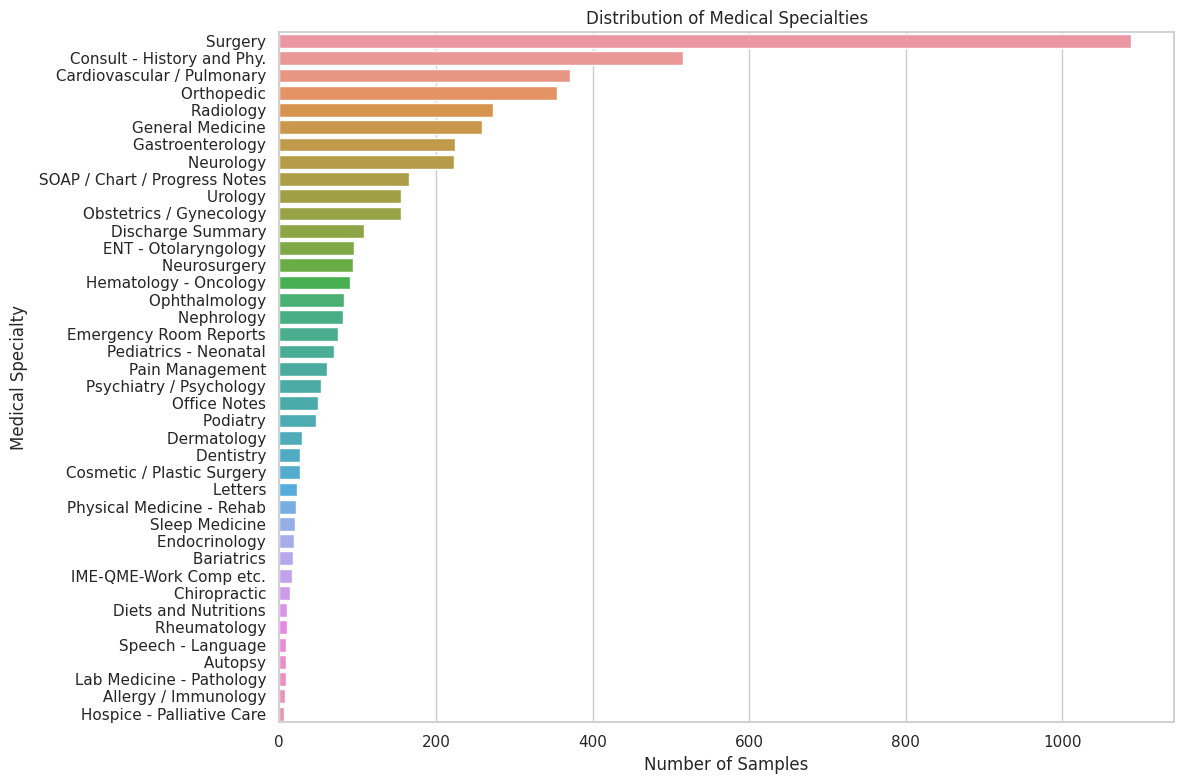

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
ax = sns.countplot(data=df, y='medical_specialty', order=df['medical_specialty'].value_counts().index)
plt.title("Distribution of Medical Specialties")
plt.xlabel("Number of Samples")
plt.ylabel("Medical Specialty")
plt.tight_layout()
plt.show()


**🔹 Sadece yeterli verisi olan sınıfları tutma işlemi yapacağız (>=20 örnek)**

* Eğitim dengeli olur, model ezberlemeden öğrenebilir.

* Eğitim süresi azalır.

* Karmaşık teknikler (ağırlık verme, oversampling) gerekmez.

In [17]:
# 20'den az örneği olan sınıfları çıkar
class_counts = df['medical_specialty'].value_counts()
valid_classes = class_counts[class_counts >= 20].index
df = df[df['medical_specialty'].isin(valid_classes)].reset_index(drop=True)

# Label'ları tekrar encode et (bazıları silinmiş olduğu için)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['medical_specialty'])

# Yeni sınıf sayısı
num_classes = df['label'].nunique()
print(f"new label count: {num_classes}")


Yeni sınıf sayısı: 29


# Train-Evaluation Split


In [23]:
#  Bu kod bloğu, eğitim verini %90 eğitim / %10 doğrulama (validation) olacak şekilde 
#  etiketlere göre dengeli biçimde bölüyor
train_df, eval_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42  # For reproducibility
)
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(eval_df)}")

Train samples: 3920
Validation samples: 436


In [26]:
# Reset index after train-validation split to clean up the DataFrames
train_df = train_df.reset_index(drop=True)
eval_df = eval_df.reset_index(drop=True)

# Convert to Hugging Face Dataset Format


In [27]:
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

# Create a DatasetDict for use with Hugging Face Trainer
dataset = DatasetDict({
    "train": train_dataset,
    "eval": eval_dataset
})

# Load DistilBERT Tokenizer

In [28]:
model_checkpoint = "distilbert-base-uncased"

# Load the tokenizer from Hugging Face
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

#Eğer tokenizer’ın pad token'ı tanımlı değilse, sonlandırma (eos) token’ı pad_token olarak atanır.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token 

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Load Pretrained DistilBERT Model for Sequence Classification

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_classes
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1. dataset.map(...)
Hugging Face Dataset nesnesi üzerinde işlem yapar.

Her örneğe (örneğin her satıra) tokenizer uygular.

Bu örnekte sadece transcription metni tokenize ediliyor.

2. truncation=True
Cümle çok uzunsa otomatik olarak 512 token'dan sonra kesiliyor (DistilBERT'in limiti).

3. batched=True
Tokenizer’ı daha hızlı çalıştırmak için örnekleri topluca işler.

4. remove_columns=["transcription", "medical_specialty", "keywords"]
Tokenizer çalıştıktan sonra artık modelin eğitimi için gerekli olmayan sütunları (metin ve etiketi içeren orijinal alanlar) dataset’ten çıkartıyor.

5. medical_specialty ise zaten label’e çevrilmişti, dolayısıyla artık ham sınıf adı tutulmak zorunda değil.


Tokenizer zaten transcription sütununu alıp onu input_ids, attention_mask gibi sayısal tensor’lara dönüştürüyor.

Bu işlem tamamlandıktan sonra, ham metne artık ihtiyaç kalmıyor.

Eğitimi daha hafif ve temiz bir dataset ile yapmak istiyoruz.

In [31]:
tokenized_dataset = dataset.map(
    lambda x: tokenizer(x["transcription"], truncation=True),
    batched=True,
    remove_columns=["transcription", "medical_specialty"]
)


Map:   0%|          | 0/3920 [00:00<?, ? examples/s]

Map:   0%|          | 0/436 [00:00<?, ? examples/s]

# Prepare the Data Collator

In [33]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define the Metric for Evaluation 

| Metric    | Avantajı                                        | Dezavantajı                               |
| --------- | ----------------------------------------------- | ----------------------------------------- |
| Accuracy  | Genelde anlaşılır ve basit                      | Dengesiz veri setlerinde yanıltıcı olur ❌ |
| F1-score  | Hem precision hem recall’ı dengeler ✅           | Yorumu biraz daha teknik                  |
| f1\_micro | Tüm sınıfları bir arada dengeli değerlendirir ✅ | Az örnekli sınıfları az etkiler           |


In [36]:
# Function to compute evaluation metrics (Validation F1 micro score)
def compute_metrics(eval_preds):
    
    logits, labels = eval_preds
    # Logit değerleri arasından en yüksek olasılığı olan sınıfı alır.
    predictions = np.argmax(logits, axis=-1)
    
    # Compute F1
    # Gerçek ve tahmin edilen sınıflar karşılaştırılır
    f1score = f1_score(labels, predictions, average='micro')
    
    return {
        "Validation f1_micro": f1score,
    }

# LoRA Configuration and Model Preparation for Training

In [37]:
# Define LoRA Parameters
LORA_R = 8  # Dimension of the low-rank matrices
LORA_ALPHA = 16  # Scaling factor for the weight matrices
LORA_DROPOUT = 0.05  # Dropout probability for the LoRA layers

# Define LoRA Config
lora_config = LoraConfig(
    r=LORA_R,  # Low-rank dimension
    lora_alpha=LORA_ALPHA,  # Scaling factor for the weight matrices
    lora_dropout=LORA_DROPOUT,  # Dropout for the LoRA layers
    bias="none",  # No bias term for LoRA layers
    task_type="SEQ_CLS",  # Sequence Classification task
    target_modules=["q_lin", "k_lin", "v_lin"],  # Target layers for LoRA in DistilBERT
)

# Prepare model for int-8 quantization training using PEFT
# modeli düşük bitli (örneğin 8-bit) parametrelerle eğitime hazır hale getirir. 
model = prepare_model_for_kbit_training(model)

# Initialize the model with the LoRA framework
# önceden yüklenen DistilBERT modeline LoRA yapılarını entegre eder.

model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

trainable params: 834,077 || all params: 67,809,850 || trainable%: 1.2300


Sadece %1’den az parametreyi eğiterek, orijinal modele çok yakın performans alırsın. İşte LoRA'nın güzelliği burada. 🎯

# 🎯 Training Arguments Configuration

In [44]:
training_args = TrainingArguments(
    output_dir="./distilbert",        # Checkpoint'ler burada kaydedilir
    report_to="none",                 # WandB, TensorBoard vs. kullanılmıyor
    per_device_train_batch_size=16,   # Eğitim batch boyutu
    per_device_eval_batch_size=8,     # Doğrulama batch boyutu (küçük tutulmuş)
    fp16=True,                        # 16-bit hassasiyet: Daha hızlı ve az GPU tüketimi
    learning_rate=2e-5,               # Öğrenme hızı 
    num_train_epochs=3,              # Eğitim turu (epoch) sayısı
    seed=42,                          # Rastgelelik kontrolü
    eval_strategy="epoch",           # Her epoch sonunda değerlendirme
    save_strategy="epoch",           # Her epoch sonunda model kaydedilir
    save_total_limit=6,             # En fazla 12 checkpoint tutulur
    load_best_model_at_end=False,    # En iyi modeli otomatik yükleme yok
    label_names=["labels"]           # `labels` sütunu kullanılacak
)


# 🎯 Trainer Configuration


In [45]:
from transformers import Trainer

trainer = Trainer(
    model=model,                             # LoRA ile optimize edilmiş model
    args=training_args,                      # Eğitim parametreleri
    train_dataset=tokenized_dataset['train'],  # Eğitim verisi
    eval_dataset=tokenized_dataset['eval'],    # Doğrulama verisi
    tokenizer=tokenizer,                     # Text decode işlemleri için tokenizer
    data_collator=data_collator,             # Dynamic padding
    compute_metrics=compute_metrics          # F1 micro hesaplama
)


# Model Training

In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,Validation f1 Micro
1,No log,1.571321,0.323394
2,No log,1.575997,0.323394
3,1.199500,1.578354,0.316514


TrainOutput(global_step=735, training_loss=1.1941924426020407, metrics={'train_runtime': 244.3084, 'train_samples_per_second': 48.136, 'train_steps_per_second': 3.008, 'total_flos': 1588699173519360.0, 'train_loss': 1.1941924426020407, 'epoch': 3.0})

In [55]:
import pandas as pd
import plotly.express as px

# 1. Tüm log kayıtlarını al
log_df = pd.DataFrame(trainer.state.log_history)

# 2. Sadece 'epoch' içeren satırları tut
log_df = log_df[log_df['epoch'].notnull()]

# 3. Eksikleri öncekiyle doldur
log_df_filled = log_df.fillna(method='ffill')

# 4. Yalnızca eval_loss içeren satırları al (yani epoch sonları)
metrics_plot_df = log_df_filled[log_df_filled['eval_loss'].notnull()]

# 5. Kolon adlarını daha okunur yap
metrics_plot_df = metrics_plot_df.rename(columns={
    'loss': 'Training Loss',
    'eval_loss': 'Validation Loss',
    'eval_Validation f1_micro': 'Validation F1 (Micro)'
})

# 6. Uzun formata çevir (Plotly için)
metrics_plot_df_melted = metrics_plot_df.melt(
    id_vars='epoch',
    value_vars=['Training Loss', 'Validation Loss', 'Validation F1 (Micro)'],
    var_name='Metric',
    value_name='Value'
)

# 7. Plotly çizimi
fig = px.line(
    metrics_plot_df_melted,
    x='epoch',
    y='Value',
    color='Metric',
    title='📈 Epoch-wise Training & Validation Metrics',
    width=900,
    height=500,
    color_discrete_map={
        'Training Loss': '#a2a2a2',
        'Validation Loss': '#a2a2a2',
        'Validation F1 (Micro)': '#27ff01'
    }
)

fig.update_layout(
    template='plotly_dark',
    xaxis_title='Epoch',
    yaxis_title='Metric Value',
    legend_title='Metric',
    font=dict(size=14)
)

fig.update_traces(selector=dict(name='Training Loss'), line=dict(dash='solid'))
fig.update_traces(selector=dict(name='Validation Loss'), line=dict(dash='solid'))
fig.update_traces(selector=dict(name='Validation F1 (Micro)'), line=dict(dash='dashdot'))

fig.show()
